# Individualized models

The approach for this notebook was to construct a model for each time series available for every product in every city. An advantage to this approach is that it can be very accurate for cities that diverge freatly from its peers, whilst also being very simple to understand and visualize. The big disadvantage it has, however, is that it cannot notice and exploit trends between groups of cities, or even between products in the same city, which might provide valuable insight.

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from multiprocessing.pool import ThreadPool
from sklearn.utils._testing import ignore_warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning

# Set global random seed for numpy and sklearn for reproducibility.
np.random.seed(42)

The provided csv has some anomalies that make loading it automatically with pre-made functions a bit problematic. This can be easily resolved with some quick parsing and cleaning up of the present data.

In [2]:
# Important to use utf-8, as 'açaí' will need a better encoding than default ascii
with open('historical-database.csv', 'r', encoding='utf-8') as f:
    data = f.read()

data = data.split('\n')
# Separating columns manually
columns = data[0]
data = data[1:-1]
# Remove ending comma, then split by semi-colon
columns = columns[:-1].split(';')

# Transform dates
def date_handler(date: pd.Timestamp):
    return date.year - 1985

# Retransform dates back to pd.Timestamp
def date_reverse(date: int) -> pd.Timestamp:
    return pd.Timestamp(date + 1985, 1, 1)

# Simple example to check that date encoding is working
# sample_date = pd.Timestamp(2015, 1, 1)
# cvt_date = date_handler(sample_date)
# print(f'{sample_date=}\n{cvt_date=}\n{date_reverse(cvt_date)=}')

def process_line(line: str) -> list:
    entries = line.split(';')
    if ',' in entries[-1] and len(entries[-1])>1:
        entries[-1] = float(entries[-1].replace(',','.',-1))
    elif len(entries[-1]) <= 1:
        entries[-1] = None
    else:
        entries[-1] = float(entries[-1])
    # Convert to python-friendly date format.
    entries[0] = datetime.datetime.strptime(entries[0],"%d/%m/%Y")
    return entries

data = list(map(process_line, data))
df_orig = pd.DataFrame(data=data, columns=columns)
df_orig['year'] = df_orig['year'].apply(date_handler)
df_orig = df_orig.drop(df_orig[df_orig['year']<0].index, axis = 0)
type_dict = [(val, tip) for tip, val in df_orig[['product_type', 'product']].value_counts().index.to_list() if val != "Others"]
type_dict.append(('Permanent-other', 'permanent'))
type_dict.append(('Temporary-other', 'temporary'))
type_dict = {prod: tip for prod, tip in type_dict}
df_orig.loc[(df_orig['product_type'] == "permanent") & (df_orig['product'] == 'Others'), 'product'] = 'Permanent-other'
df_orig.loc[(df_orig['product_type'] == "temporary") & (df_orig['product'] == 'Others'), 'product'] = 'Temporary-other'
df_orig = df_orig.drop('product_type', axis=1)
df = df_orig.copy(deep=True)
df_orig

,year,city_code,product,destinated_area
1573,0,960b4f2c94a2fb2c,Temporary-other,0.0000
1574,0,746cc42bfb8f6b62,Temporary-other,0.0000
1575,0,6cce2bf873870afc,Temporary-other,0.0000
1576,0,4de42e351006a2ae,Temporary-other,0.0000
1577,0,5b6072f8f6d37acc,Temporary-other,0.0000
...,...,...,...,...
73739,28,74d75dde6dc4a5ec,Livestock,150866.5644
73740,29,74d75dde6dc4a5ec,Livestock,152446.3960
73741,30,74d75dde6dc4a5ec,Livestock,154681.0205
73742,31,74d75dde6dc4a5ec,Livestock,164706.2778


Upon inspecting the available data, it was possible to notice that the first 10 years were essentially useless, as most if not all products for most cities had no record from those periods. As such, the first 11 years (1974 to 1984) were removed, leaving the data with a start year of 1985. These years were then ordinaly encoded manually, as this type of feature with high cardinality often benefits from this type of encoding. 

After that, we check for still missing values.

In [3]:
df.isna().sum(axis=0)

year                   0
city_code              0
product                0
destinated_area    24933
dtype: int64

Clearly, there a lot of missing values. This is very important to note, since in some cases, a city might not have any records for a certain product, for example, city '8e0eb10270d768f8' might never have had any records regarding the destined area for planting Sorghum. This means that accurately predicting this value is not possible. The best one may do, is to simply assume that it has always been zero, and as such, will remain zero. There is another case that is quite common, which is records starting at some point after the beginning of the records, and occasionaly faltering. In this case, where possible, we choose to interpolate the data to fill gaps, and assume it was 0 until the beginning of known records. In some cases, we not only don't know what area was destinated for a product, we don't even have an entry for this product in the dataset, for example, a city might never even appear alongside a product in the csv, as seen below for city '807c5037e6993f2c'.

In [4]:
# Should show all 44 years of Sorghum on record for city 807c5037e6993f2c, even though it may be all null
df_orig[(df_orig['city_code'] == '807c5037e6993f2c') & (df_orig['product'] == 'Sorghum')]

,year,city_code,product,destinated_area


# Model construction

First and approach using polynomial features and an ElasticNet linear regressor was attempted. This however, yielded  very high error rates, as high as 20000 total error. Then, an idea was tested to instead predict not the area, but the change in area over the year in question (predictions for area would therefore be the sum of the area and the value produced by the model), but this only increased the error.

The second approach came in the form of a Random Forest Regressor, which was producing much smaller errors, with total errors as low as 900. This model was chosen for the final submission.

Below, all transforms and calculations were encapsulated into functions, which allows for better readablity, maintenability, and also allow for parallel training of the models in development. This speeds up the development cycle tremensously, such as reducing training times by as much as 80% on certain scenarios.

In [5]:
# Separating df by city
def df_for_city(city_code: str) -> pd.DataFrame:
    global df
    return df[df['city_code'] == city_code]

def show_crops(dataframe: pd.DataFrame):
    '''
    Show every crop's progression over every year on the database.
    '''
    fig = plt.figure(figsize=(16,20))
    axList = []
    for i, prod in enumerate(list(dataframe['product'].value_counts().index)):
        # print(i, prod)
        sub_df = dataframe[dataframe['product'] == prod][['destinated_area','year']].sort_values('year', ascending=True)
        axList.append(fig.add_subplot(4,3,i+1))
        axList[i].set_title(prod)
        axList[i].plot(sub_df['year'], sub_df['destinated_area'])
    fig.show()

def construct_city_db(curr_city_code: str) -> pd.DataFrame:
    '''
    Given a city code, extract all lines for that city
    '''
    curr_df = df_for_city(curr_city_code).drop('city_code', axis=1)
    return curr_df

def treat_missing(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Given a dataframe for a single city, treat all missing values as best as possible;
    '''
    dfs=[]
    for i, prod in enumerate(list(dataframe['product'].value_counts().index)):
            # Extract relevant columns for this product
            sub_df = dataframe[dataframe['product'] == prod].sort_values('year')
            # Determine how many points are missing
            null_values = sub_df['destinated_area'].isna().sum()
            # If all points are missing, assume always 0
            if null_values == len(list(sub_df.index)):
                    sub_df.loc[sub_df['product'] == prod,'destinated_area'] = 0
                    # print(prod, null_values, sub_df)
            # If you have some data, interpolate to determine missing points in between
            if null_values != 0:
                    # Interpolate where possible
                    sub_df = sub_df.interpolate(axis=0)
                    # Fill with 0 where can't extrapolate
                    sub_df = sub_df.fillna(0.0)
            dfs.append(sub_df)
    return pd.concat(dfs)   
            
# Now that data is somewhat smoothed and cleaned up
# We begin splitting and training

class ConstantPredictor():
    '''
    Simple predictor class to always return a constant value (mostly to handle cases where we have no data)
    '''

    def __init__(self, k):
        self.k = k
        self.out_shape=(1,1)
    
    def fit(self, x=[], y=[]):
        pass

    def predict(self, X):
        return np.ones(X.shape[0])*self.k

def break_by_city(dataframe: pd.DataFrame) -> list:
    '''
    Given a dataframe for a single city, separate into separate dataframes by product;
    '''
    dataframes={}
    for i, prod in enumerate(list(dataframe['product'].value_counts().index)):
            # Extract relevant columns for this product
            sub_dataframe = dataframe[dataframe['product'] == prod].sort_values('year')
            dataframes[prod] = (sub_dataframe.reset_index().drop(['index', 'product'], axis=1))
    return dataframes

def train_test_split(dataframe: pd.DataFrame) -> list:
    '''
    Function that takes the dataframe of a single product, in a single city, and separates the last two years as test data
    '''
    global FINAL_YEAR
    TEST = dataframe[dataframe['year'] > FINAL_YEAR - 2]
    TRAIN = dataframe[dataframe['year'] <= FINAL_YEAR - 2]
    X_test = TEST[['year']]
    y_test = TEST[['destinated_area']]
    X_train = TRAIN[['year']]
    y_train = TRAIN[['destinated_area']]
    if DIFF:
        y_train = y_train.diff(axis=0)
    return [np.array(i) for i in [X_train, y_train.fillna(0), X_test, y_test]]

def plot_regressions(dataframe: pd.DataFrame) -> None:
    '''
    Function to help visualize the quality of the regression models. Receives a dataframe for a single city
    '''
    fig = plt.figure(figsize=(16,20))
    axList = []
    for i, p in enumerate(list(dataframe['product'].value_counts().index)):
        p_dataframe = break_by_city(dataframe)[p]
        # Homemade function to separate last 2 years as test for validation
        X_train, y_train, X_test, y_test = train_test_split(p_dataframe)
        # print(f'{X_train.shape=}\n{X_test.shape=}\n{y_train.shape=}\n{y_test.shape=}')
        # If empty:
        if X_train.shape[0] == 0 or X_test.shape[0] == 0:
            continue
        # Create polynomial features to capture nuances of data better
        polfeat = PolynomialFeatures(**default_polynomial_feat_params)
        X_train_poly = polfeat.fit_transform(X_train)

        # If values are always zero, always predict 0.
        if(np.abs(y_train).sum() < 1e-2):
            reg = ConstantPredictor(0)
        else:
            # Use L1 and L2 regularization to prevent overfitting and only use features that actually help
            reg = RandomForestRegressor(**default_random_forest_params)
            reg.fit(X_train_poly, y_train.ravel())

        axList.append(fig.add_subplot(4,3,i+1))
        axList[i].set_title(p)
        axList[i].plot(X_train, reg.predict(X_train_poly), c='r', label='Model')
        axList[i].plot(X_train, y_train, label = 'Data')
        axList[i].legend()
    fig.show()

@ignore_warnings(category=ConvergenceWarning)
def make_predictions(dataframe: pd.DataFrame):
    '''
    Given a dataframe of a city, creates, then applies a regressor to each product, then returns the prediction for the two years of validation.
    '''
    predictions = []
    for i, p in enumerate(list(dataframe['product'].value_counts().index)):
        p_dataframe = break_by_city(dataframe)[p]
        # Homemade function to separate last 2 years as test for validation
        X_train, y_train, X_test, y_test = train_test_split(p_dataframe)
        # Unknown product for this city
        if X_train.shape[0] == 0 or X_test.shape[0] == 0:
            # Make two predictions of 0
            if PRODUCTION:
                predictions.append([[int(t), p, 0.0] for t in X_test.T[0]])
            else:
                predictions.append([[0, 0],[0, 0]])
            continue
        # print(p)
        # print(X_test.T)
        # print(f'{X_train.shape=}\n{X_test.shape=}\n{y_train.shape=}\n{y_test.shape=}')
        # Create polynomial features to capture nuances of data better
        polfeat = PolynomialFeatures(**default_polynomial_feat_params)
        X_train_poly = polfeat.fit_transform(X_train)

        # If values are always zero, always predict 0.
        if(np.abs(y_train).sum() < 1e-2):
            reg = ConstantPredictor(0)
        else:
            # Use L1 and L2 regularization to prevent overfitting and only use features that actually help
            # reg = ElasticNet(**default_elastic_net_params)
            reg = RandomForestRegressor(**default_random_forest_params)
            reg.fit(X_train_poly, y_train.ravel())
        X_test_poly = polfeat.transform(X_test)
        y_pred = reg.predict(X_test_poly)
        # print(y_pred)
        if PRODUCTION:
            predictions.append([[int(t), p, float(r)] for r, t in zip(y_pred, X_test.T[0])])
        else:
            predictions.append([[t, r] for t, r in zip(y_pred,y_test[:,0])])
    predictions = np.array(predictions)
    if PRODUCTION:
        # print(predictions)
        return np.concatenate([predictions[:,0], predictions[:,1]])
    return predictions

def score_predictions(pred: list) -> int:
    '''
    Calculate the score (WMAPE) for the predictions given. Input is meant to be same format as 'make_predictions' output.
    '''
    def wmape(y):
        y_pred, y_true = y
        if y_true < 1e-2:
            return abs(y_true-y_pred)
        return abs(y_true-y_pred)/abs(y_true)
    return sum(list(map(wmape, pred[:,0])))

def transform_to_output_format(pred) -> pd.DataFrame:
    '''
    Modify predictions to fit the requested final format for submission.
    '''
    city_code = list(pred.keys())[0]
    dataframe = pd.DataFrame(data=list(pred.values())[0], columns=['year', 'product', 'predicted_area_change'])
    dataframe['year'] = dataframe['year'].astype(np.int64)
    dataframe['predicted_area_change'] = dataframe['predicted_area_change'].astype(np.float64)
    base = df[(df['city_code'] == city_code)&(df['year'] == FINAL_YEAR - 2)].fillna(0).reset_index()
    new_areas = []
    for p in set(dataframe['product']):
        area_2018 = list(dataframe[(dataframe['product'] == p) & (dataframe['year'] == FINAL_YEAR - 1)]['predicted_area_change'])[0]#+area
        area_2019 = list(dataframe[(dataframe['product'] == p) & (dataframe['year'] == FINAL_YEAR)]['predicted_area_change'])[0]#+area_2018
        # If predicting on difference to next year, add to baseline for actual total area
        if DIFF:
            area = list(base[base['product'] == p]['destinated_area'])[0]
            area_2018 += area
            area_2019 += area_2018
        if area_2018 < 0:
            area_2018 = 0.0
        if area_2019 < 0:
            area_2019 = 0.0
        new_areas.append([date_reverse(FINAL_YEAR - 1), city_code, type_dict[p], p, area_2018])
        new_areas.append([date_reverse(FINAL_YEAR), city_code, type_dict[p], p, area_2019])
    return pd.DataFrame(data=new_areas, columns=['year','city_code','product_type','product','destinated_area'])

@ignore_warnings(category=ConvergenceWarning)
def make_score_for_city(city_code: str, show_graphs = False) -> int:
    '''
    Wrapper function for training process, calls other functions developed above.
    '''
    dataframe = construct_city_db(city_code)
    dataframe = treat_missing(dataframe)
    pred = make_predictions(dataframe)
    if show_graphs:
        plot_regressions(dataframe)
    if PRODUCTION:
        return transform_to_output_format({city_code: pred})
    return score_predictions(pred)

Below, some control variables allow for centralized parameter changes and tranining control. It also handles adding the additional rows for the 2 future years in case the model is ready for production.

In [6]:
# Define standard params for models in dictionaries
default_elastic_net_params = {'alpha':1, 'random_state':42, 'max_iter':10000000, 'tol':1e-1, 'fit_intercept':False}
default_random_forest_params = {'n_estimators':100, 'random_state':42, 'n_jobs': -1, 'criterion':'absolute_error', 'bootstrap':True}
# Degree is 15 to allow for possible capture of high speed change, while also beign kept in check by regularization.
default_polynomial_feat_params = {'degree':15, 'include_bias':False}
PRODUCTION = True
DIFF = False
# Insert two next years into df for final predictions

UNIQUE_PRODUCT_LIST = list(set(df['product'].value_counts().index))
UNIQUE_CITY_CODES = list(set(df['city_code'].value_counts().index))
FINAL_YEAR = df_orig['year'].max()

df = df_orig.copy(deep=True)
if PRODUCTION:
    for city in UNIQUE_CITY_CODES:
        for prod in UNIQUE_PRODUCT_LIST:
            sm_df = pd.DataFrame(data=[[FINAL_YEAR+1, city, prod, np.nan], [FINAL_YEAR+2, city, prod, np.nan]], columns=df.columns)
            df = pd.concat([df, sm_df])  
    FINAL_YEAR += 2      
        
df = df.reset_index().drop('index',axis=1)
df

,year,city_code,product,destinated_area
0,0,960b4f2c94a2fb2c,Temporary-other,0.0
1,0,746cc42bfb8f6b62,Temporary-other,0.0
2,0,6cce2bf873870afc,Temporary-other,0.0
3,0,4de42e351006a2ae,Temporary-other,0.0
4,0,5b6072f8f6d37acc,Temporary-other,0.0
...,...,...,...,...
59947,34,205ccde9be499e17,Soy,NaN
59948,33,205ccde9be499e17,Açaí,NaN
59949,34,205ccde9be499e17,Açaí,NaN
59950,33,205ccde9be499e17,Sorghum,NaN


# Execution and results

Below, we use python's multiprocessing to run the training in parallel. We also save some resulting predictions in csv files for ease of analysis later. After training on the entirety of the training set (up to 2016 if not in production, or all of it otherwise), we run the code once more with a random city selected, and plot the regression results. This is so that we can understand how the model is behaving, and verify that nothing weird or unexpected is happening.

Example analysis for random city: 051e9cc7d7636816


C:\Users\Cadu Dip\AppData\Local\Temp\ipykernel_1680\441025316.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


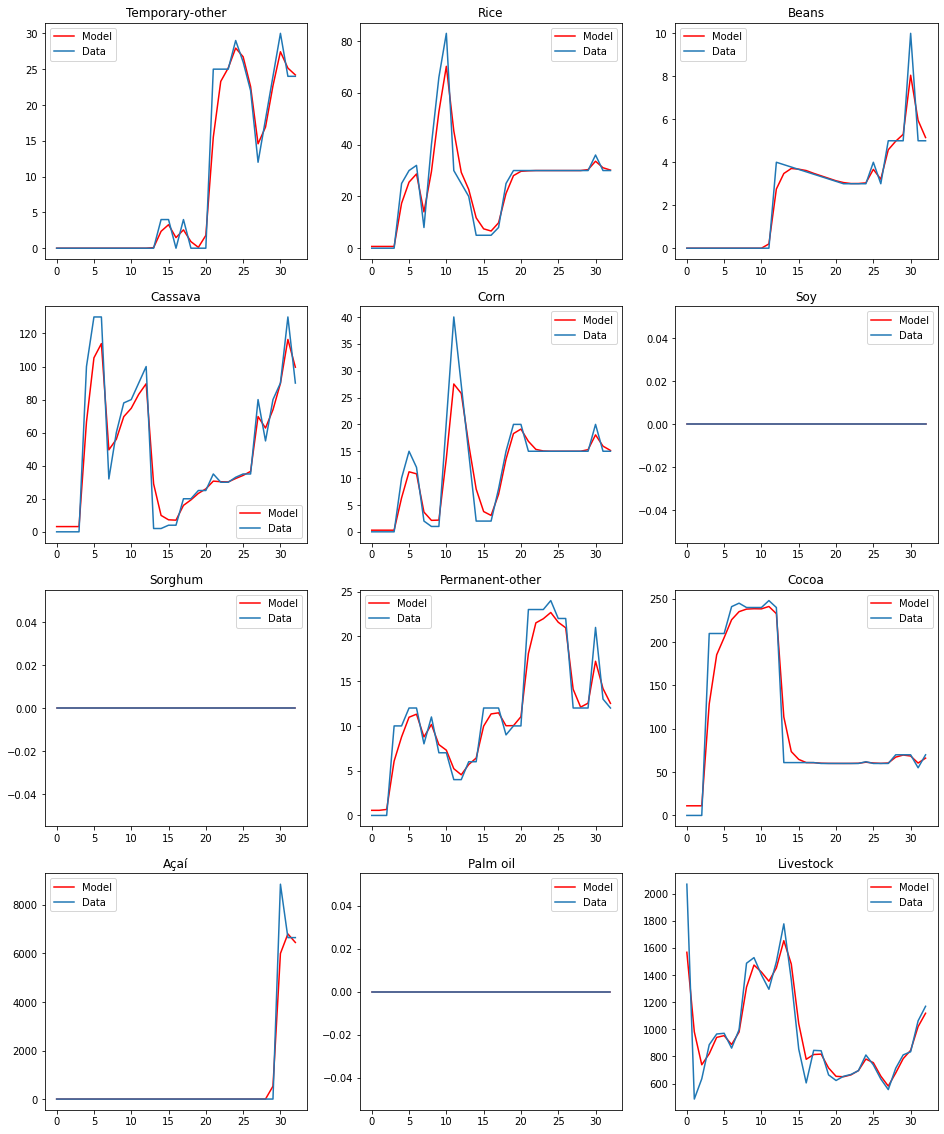

In [7]:
# Launch training in parallel
with ThreadPool(16) as p:
    a = p.map(make_score_for_city, UNIQUE_CITY_CODES)

if PRODUCTION:
    final_df = pd.concat(a).sort_values('city_code').reset_index().drop('index', axis=1)
    final_df.to_csv('./results/LG65VP.csv')
else:
    print(f"Total acumulated WMAPE error for parameters {DIFF=}, Polynomial Features Degree:={default_polynomial_feat_params['degree']}: {sum(a)}")
    if DIFF:
        pd.DataFrame([[a,b] for a, b in zip(a, UNIQUE_CITY_CODES)],columns=['WMAPE', 'city_code']).to_csv('./results/city_clustering_v2_diff.csv')
    else:
        pd.DataFrame([[a,b] for a, b in zip(a, UNIQUE_CITY_CODES)],columns=['WMAPE', 'city_code']).to_csv('./results/city_clustering_v2.csv')

city = np.random.choice(UNIQUE_CITY_CODES)
print("Example analysis for random city: {0}".format(city))
pred_df = make_score_for_city(city, show_graphs=True);

After running both styles of analysis (difference vs. total area prediction), we saved them to csv, and below show the results for comparison.

Predicting difference in area yielded a total error of 1629.9250989431541 with an average error of 11.318924298216343
Predicting area directly yielded a total error of 889.7451132836528 with an average error of 6.178785508914256


C:\Users\Cadu Dip\AppData\Local\Temp\ipykernel_1680\3203182664.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


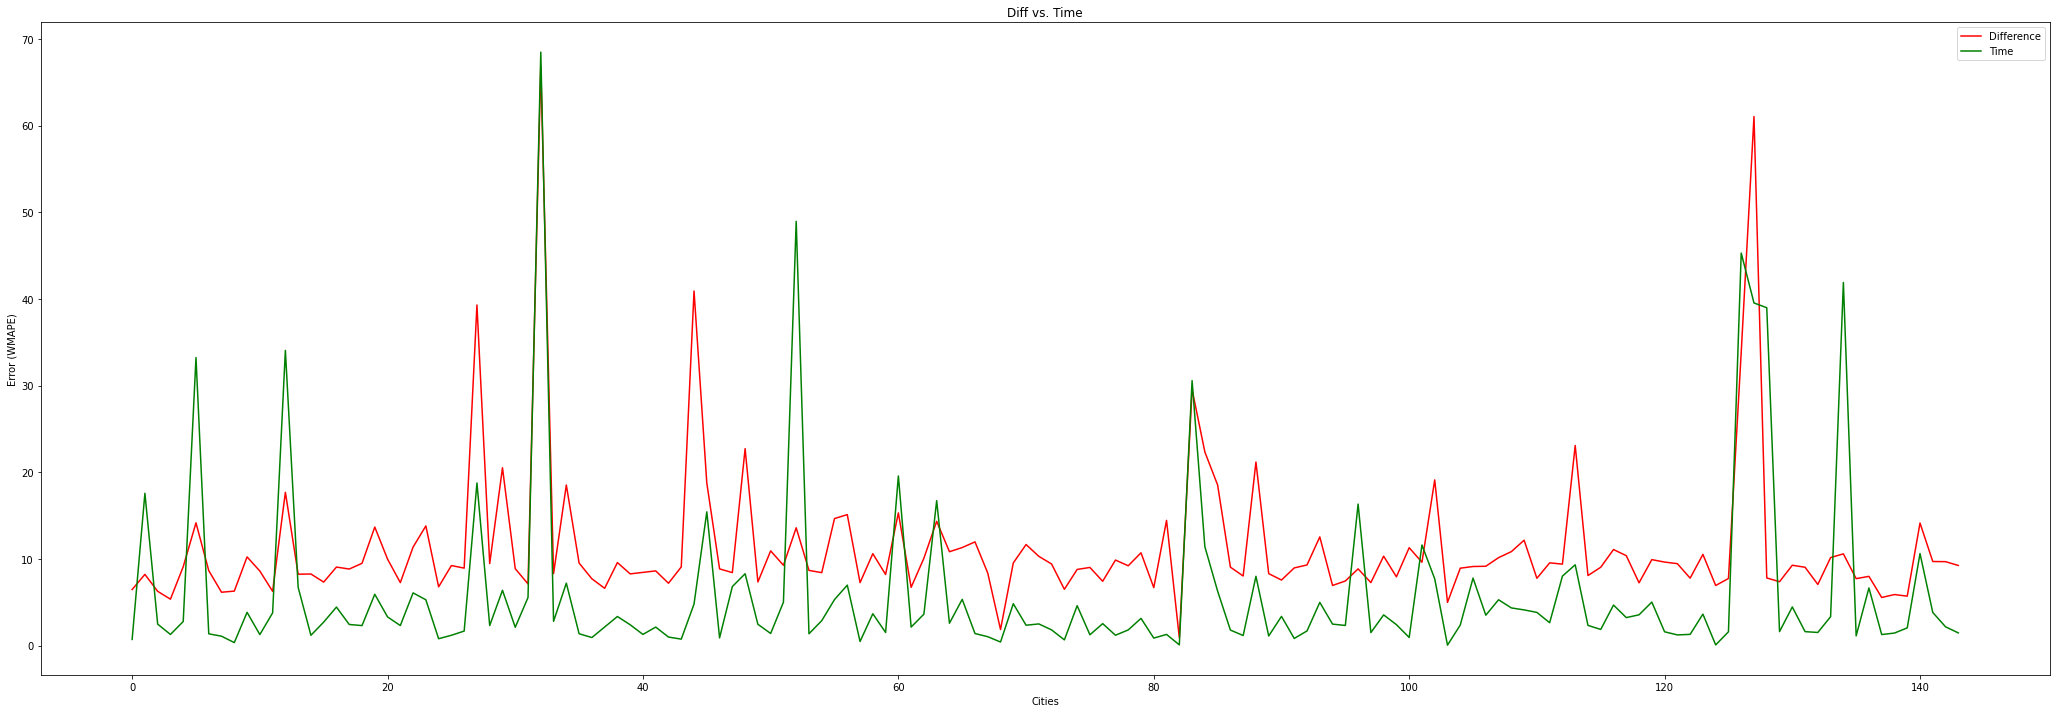

In [10]:
# Analyse if DIFF helps
df_diff = pd.read_csv('./results/city_clustering_v2_diff.csv', index_col = 0).sort_values('city_code').reset_index().drop('index', axis=1)
df_time = pd.read_csv('./results/city_clustering_v2.csv', index_col = 0).sort_values('city_code').reset_index().drop('index', axis=1)
y_diff = list(df_diff['WMAPE'])
y_time = list(df_time['WMAPE'])
x = list(df_diff['city_code'])
print(f'Predicting difference in area yielded a total error of {sum(y_diff)} with an average error of {np.mean(y_diff)}')
print(f'Predicting area directly yielded a total error of {sum(y_time)} with an average error of {np.mean(y_time)}')
# Plot
fig = plt.figure(figsize=(36,12))
ax = fig.add_subplot(111)
ax.set_title("Diff vs. Time")
ax.plot(range(len(x)), y_diff, c='r', label='Difference')
ax.plot(range(len(x)), y_time, c='g', label = 'Time')
ax.set_xlabel('Cities')
ax.set_ylabel('Error (WMAPE)')
# ax.set_xticks(range(len(x))) 
# ax.set_xticklabels(x, rotation=45, ha='center')
ax.legend()
fig.show()


As can be seen above, predicting the total area directly produced slightly smaller errors in general. Below we then show the distribution of the errors for the total area predictions, to see if there is any grave anomalies. Since this shows the error on an absolute scale (no negatives), the slight right-sidedness to the distribution is understandable, and it is possible to see that the values themselves do tend to be quite small, which is very good.

C:\Users\Cadu Dip\AppData\Local\Temp\ipykernel_1680\885044380.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


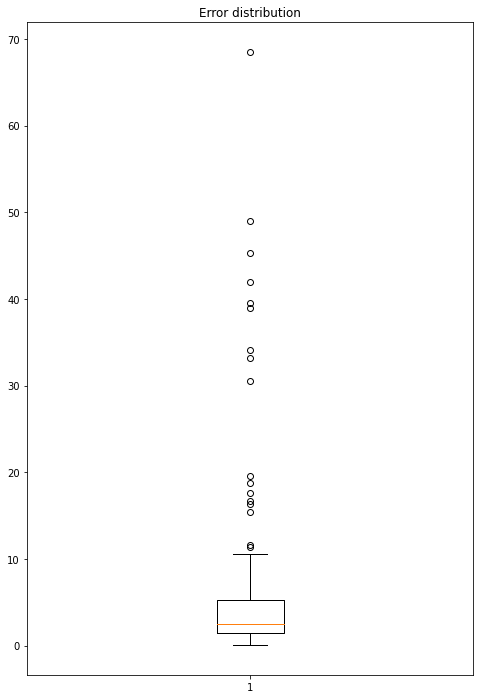

In [9]:
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111)
ax.set_title("Error distribution")
# ax.hist(df_time['WMAPE'], bins=len(err), density=True)
ax.boxplot(df_time['WMAPE'])

fig.show()